# Method 8 - Best Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data.groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

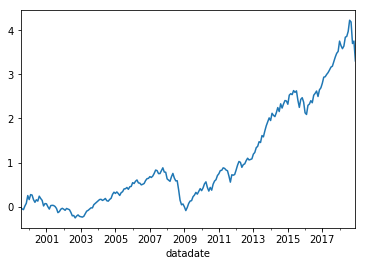

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.251692
2000-12-31   -0.145084
2001-12-31   -0.100127
2002-12-31   -0.189536
2003-12-31    0.412976
2004-12-31    0.204675
2005-12-31    0.098707
2006-12-31    0.125132
2007-12-31    0.084554
2008-12-31   -0.404104
2009-12-31    0.328004
2010-12-31    0.210256
2011-12-31    0.013883
2012-12-31    0.205466
2013-12-31    0.445434
2014-12-31    0.127423
2015-12-31   -0.008045
2016-12-31    0.096514
2017-12-31    0.223460
2018-12-31   -0.047546
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     856.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.91e-136
Time:                        07:14:39   Log-Likelihood:                 712.00
No. Observations:                 234   AIC:                            -1414.
Df Residuals:                     229   BIC:                            -1397.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.718      0.007       0.001       0.004
mktrf          0.9900      0.022     45.490      0.000       0.947       1.033
me             0.2600      0.025     10.270      0.000       0.210       0.310
ia            -0.1603      0.038     -4.167      0.000      -0.236      -0.085
roe            0.1436      0.033      4.360      0.000       0.079       0.208
==============================================================================
Omnibus:                       53.722   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.246
Skew:                           0.571   Prob(JB):                    4.21e-101
Kurtosis:                       9.790   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     470.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.58e-109
Time:                        07:14:39   Log-Likelihood:                 712.00
No. Observations:                 234   AIC:                            -1414.
Df Residuals:                     229   BIC:                            -1397.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.148      0.002       0.001       0.004
mktrf          0.9900      0.029     34.280      0.000       0.933       1.047
me             0.2600      0.029      8.926      0.000       0.203       0.317
ia            -0.1603      0.092     -1.735      0.083      -0.341       0.021
roe            0.1436      0.042      3.417      0.001       0.061       0.226
==============================================================================
Omnibus:                       53.722   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.246
Skew:                           0.571   Prob(JB):                    4.21e-101
Kurtosis:                       9.790   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     532.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.22e-114
Time:                        07:14:39   Log-Likelihood:                 712.00
No. Observations:                 234   AIC:                            -1414.
Df Residuals:                     229   BIC:                            -1397.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.036      0.002       0.001       0.004
mktrf          0.9900      0.028     35.471      0.000       0.935       1.045
me             0.2600      0.031      8.429      0.000       0.200       0.320
ia            -0.1603      0.082     -1.948      0.051      -0.322       0.001
roe            0.1436      0.040      3.577      0.000       0.065       0.222
==============================================================================
Omnibus:                       53.722   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.246
Skew:                           0.571   Prob(JB):                    4.21e-101
Kurtosis:                       9.790   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     599.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.47e-129
Time:                        07:14:39   Log-Likelihood:                 697.90
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     228   BIC:                            -1363.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.958      0.003       0.001       0.004
mktrf          0.9682      0.023     41.712      0.000       0.922       1.014
smb            0.2572      0.031      8.398      0.000       0.197       0.318
hml           -0.1006      0.036     -2.786      0.006      -0.172      -0.029
rmw            0.0561      0.041      1.374      0.171      -0.024       0.137
cma           -0.0318      0.052     -0.612      0.541      -0.134       0.070
==============================================================================
Omnibus:                       42.056   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.955
Skew:                           0.271   Prob(JB):                     1.70e-81
Kurtosis:                       9.153   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     633.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.70e-131
Time:                        07:14:39   Log-Likelihood:                 697.90
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     228   BIC:                            -1363.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      3.066      0.002       0.001       0.004
mktrf          0.9682      0.028     34.264      0.000       0.913       1.024
smb            0.2572      0.034      7.492      0.000       0.190       0.324
hml           -0.1006      0.056     -1.810      0.070      -0.210       0.008
rmw            0.0561      0.049      1.153      0.249      -0.039       0.151
cma           -0.0318      0.122     -0.260      0.795      -0.271       0.208
==============================================================================
Omnibus:                       42.056   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.955
Skew:                           0.271   Prob(JB):                     1.70e-81
Kurtosis:                       9.153   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     752.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.72e-139
Time:                        07:14:39   Log-Likelihood:                 697.90
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     228   BIC:                            -1363.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.927      0.003       0.001       0.004
mktrf          0.9682      0.029     33.879      0.000       0.912       1.024
smb            0.2572      0.033      7.748      0.000       0.192       0.322
hml           -0.1006      0.059     -1.720      0.085      -0.215       0.014
rmw            0.0561      0.047      1.188      0.235      -0.036       0.149
cma           -0.0318      0.125     -0.254      0.800      -0.277       0.214
==============================================================================
Omnibus:                       42.056   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.955
Skew:                           0.271   Prob(JB):                     1.70e-81
Kurtosis:                       9.153   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1075.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.18e-147
Time:                        07:14:39   Log-Likelihood:                 737.10
No. Observations:                 234   AIC:                            -1464.
Df Residuals:                     229   BIC:                            -1447.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.700      0.007       0.001       0.003
mktrf          1.0349      0.018     57.500      0.000       0.999       1.070
smb            0.1654      0.022      7.363      0.000       0.121       0.210
hml           -0.0159      0.022     -0.711      0.478      -0.060       0.028
umd            0.1484      0.015     10.136      0.000       0.120       0.177
==============================================================================
Omnibus:                       25.596   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.732
Skew:                          -0.122   Prob(JB):                     6.07e-27
Kurtosis:                       6.510   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1001.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.87e-144
Time:                        07:14:39   Log-Likelihood:                 737.10
No. Observations:                 234   AIC:                            -1464.
Df Residuals:                     229   BIC:                            -1447.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.877      0.004       0.001       0.003
mktrf          1.0349      0.028     36.331      0.000       0.979       1.091
smb            0.1654      0.030      5.444      0.000       0.106       0.225
hml           -0.0159      0.044     -0.364      0.716      -0.101       0.070
umd            0.1484      0.030      4.878      0.000       0.089       0.208
==============================================================================
Omnibus:                       25.596   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.732
Skew:                          -0.122   Prob(JB):                     6.07e-27
Kurtosis:                       6.510   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1230.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.84e-153
Time:                        07:14:39   Log-Likelihood:                 737.10
No. Observations:                 234   AIC:                            -1464.
Df Residuals:                     229   BIC:                            -1447.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.972      0.003       0.001       0.003
mktrf          1.0349      0.029     35.999      0.000       0.979       1.091
smb            0.1654      0.032      5.179      0.000       0.103       0.228
hml           -0.0159      0.041     -0.383      0.702      -0.097       0.065
umd            0.1484      0.030      5.030      0.000       0.091       0.206
==============================================================================
Omnibus:                       25.596   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.732
Skew:                          -0.122   Prob(JB):                     6.07e-27
Kurtosis:                       6.510   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     368.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.48e-64
Time:                        07:14:39   Log-Likelihood:                 342.95
No. Observations:                 120   AIC:                            -675.9
Df Residuals:                     115   BIC:                            -662.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.247      0.215      -0.001       0.004
mktrf          1.0342      0.037     28.286      0.000       0.962       1.107
me             0.2839      0.036      7.862      0.000       0.212       0.355
ia            -0.1573      0.057     -2.782      0.006      -0.269      -0.045
roe            0.2238      0.050      4.471      0.000       0.125       0.323
==============================================================================
Omnibus:                       32.179   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.435
Skew:                           0.763   Prob(JB):                     2.63e-32
Kurtosis:                       8.173   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     194.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.05e-50
Time:                        07:14:39   Log-Likelihood:                 342.95
No. Observations:                 120   AIC:                            -675.9
Df Residuals:                     115   BIC:                            -662.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.652      0.098      -0.000       0.004
mktrf          1.0342      0.048     21.382      0.000       0.939       1.129
me             0.2839      0.039      7.340      0.000       0.208       0.360
ia            -0.1573      0.117     -1.348      0.178      -0.386       0.072
roe            0.2238      0.047      4.806      0.000       0.133       0.315
==============================================================================
Omnibus:                       32.179   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.435
Skew:                           0.763   Prob(JB):                     2.63e-32
Kurtosis:                       8.173   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     229.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.25e-54
Time:                        07:14:39   Log-Likelihood:                 342.95
No. Observations:                 120   AIC:                            -675.9
Df Residuals:                     115   BIC:                            -662.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.704      0.088      -0.000       0.004
mktrf          1.0342      0.043     24.045      0.000       0.950       1.119
me             0.2839      0.041      7.010      0.000       0.205       0.363
ia            -0.1573      0.104     -1.508      0.131      -0.362       0.047
roe            0.2238      0.032      7.056      0.000       0.162       0.286
==============================================================================
Omnibus:                       32.179   Durbin-Watson:                   2.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.435
Skew:                           0.763   Prob(JB):                     2.63e-32
Kurtosis:                       8.173   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     230.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.97e-58
Time:                        07:14:39   Log-Likelihood:                 329.92
No. Observations:                 120   AIC:                            -647.8
Df Residuals:                     114   BIC:                            -631.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.808      0.073      -0.000       0.006
mktrf          1.0062      0.043     23.312      0.000       0.921       1.092
smb            0.2838      0.049      5.806      0.000       0.187       0.381
hml           -0.1538      0.060     -2.567      0.012      -0.272      -0.035
rmw            0.1269      0.071      1.796      0.075      -0.013       0.267
cma            0.0372      0.077      0.481      0.631      -0.116       0.191
==============================================================================
Omnibus:                       16.207   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.277
Skew:                           0.236   Prob(JB):                     3.65e-13
Kurtosis:                       6.351   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     208.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-55
Time:                        07:14:39   Log-Likelihood:                 329.92
No. Observations:                 120   AIC:                            -647.8
Df Residuals:                     114   BIC:                            -631.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.000      0.046    5.62e-05       0.006
mktrf          1.0062      0.055     18.281      0.000       0.898       1.114
smb            0.2838      0.051      5.564      0.000       0.184       0.384
hml           -0.1538      0.085     -1.805      0.071      -0.321       0.013
rmw            0.1269      0.081      1.558      0.119      -0.033       0.286
cma            0.0372      0.153      0.244      0.807      -0.262       0.337
==============================================================================
Omnibus:                       16.207   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.277
Skew:                           0.236   Prob(JB):                     3.65e-13
Kurtosis:                       6.351   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     207.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.51e-55
Time:                        07:14:39   Log-Likelihood:                 329.92
No. Observations:                 120   AIC:                            -647.8
Df Residuals:                     114   BIC:                            -631.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      1.894      0.058   -9.78e-05       0.006
mktrf          1.0062      0.055     18.158      0.000       0.898       1.115
smb            0.2838      0.046      6.158      0.000       0.193       0.374
hml           -0.1538      0.092     -1.670      0.095      -0.334       0.027
rmw            0.1269      0.080      1.595      0.111      -0.029       0.283
cma            0.0372      0.155      0.240      0.811      -0.267       0.342
==============================================================================
Omnibus:                       16.207   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.277
Skew:                           0.236   Prob(JB):                     3.65e-13
Kurtosis:                       6.351   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     487.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.09e-71
Time:                        07:14:39   Log-Likelihood:                 358.72
No. Observations:                 120   AIC:                            -707.4
Df Residuals:                     115   BIC:                            -693.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.728      0.007       0.001       0.005
mktrf          1.0825      0.028     38.330      0.000       1.027       1.138
smb            0.1359      0.032      4.226      0.000       0.072       0.200
hml           -0.0069      0.032     -0.213      0.832      -0.071       0.057
umd            0.1792      0.020      9.022      0.000       0.140       0.218
==============================================================================
Omnibus:                       16.444   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.560
Skew:                          -0.429   Prob(JB):                     5.73e-10
Kurtosis:                       5.788   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     589.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-75
Time:                        07:14:39   Log-Likelihood:                 358.72
No. Observations:                 120   AIC:                            -707.4
Df Residuals:                     115   BIC:                            -693.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.520      0.000       0.001       0.005
mktrf          1.0825      0.038     28.444      0.000       1.008       1.157
smb            0.1359      0.035      3.852      0.000       0.067       0.205
hml           -0.0069      0.053     -0.130      0.897      -0.111       0.097
umd            0.1792      0.034      5.329      0.000       0.113       0.245
==============================================================================
Omnibus:                       16.444   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.560
Skew:                          -0.429   Prob(JB):                     5.73e-10
Kurtosis:                       5.788   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     963.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.07e-87
Time:                        07:14:39   Log-Likelihood:                 358.72
No. Observations:                 120   AIC:                            -707.4
Df Residuals:                     115   BIC:                            -693.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.983      0.000       0.002       0.005
mktrf          1.0825      0.033     32.624      0.000       1.018       1.148
smb            0.1359      0.034      3.988      0.000       0.069       0.203
hml           -0.0069      0.050     -0.136      0.891      -0.105       0.092
umd            0.1792      0.027      6.678      0.000       0.127       0.232
==============================================================================
Omnibus:                       16.444   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.560
Skew:                          -0.429   Prob(JB):                     5.73e-10
Kurtosis:                       5.788   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     733.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.64e-78
Time:                        07:14:39   Log-Likelihood:                 398.26
No. Observations:                 114   AIC:                            -786.5
Df Residuals:                     109   BIC:                            -772.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.836      0.000       0.001       0.004
mktrf          0.9596      0.022     43.393      0.000       0.916       1.003
me             0.2069      0.034      6.061      0.000       0.139       0.275
ia            -0.2200      0.047     -4.646      0.000      -0.314      -0.126
roe           -0.0505      0.042     -1.213      0.228      -0.133       0.032
==============================================================================
Omnibus:                        0.143   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.154
Skew:                           0.079   Prob(JB):                        0.926
Kurtosis:                       2.915   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     912.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.34e-83
Time:                        07:14:39   Log-Likelihood:                 398.26
No. Observations:                 114   AIC:                            -786.5
Df Residuals:                     109   BIC:                            -772.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.342      0.001       0.001       0.005
mktrf          0.9596      0.017     55.269      0.000       0.926       0.994
me             0.2069      0.037      5.643      0.000       0.135       0.279
ia            -0.2200      0.052     -4.205      0.000      -0.323      -0.117
roe           -0.0505      0.046     -1.088      0.277      -0.141       0.040
==============================================================================
Omnibus:                        0.143   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.154
Skew:                           0.079   Prob(JB):                        0.926
Kurtosis:                       2.915   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1259.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.18e-90
Time:                        07:14:39   Log-Likelihood:                 398.26
No. Observations:                 114   AIC:                            -786.5
Df Residuals:                     109   BIC:                            -772.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.092      0.002       0.001       0.005
mktrf          0.9596      0.015     63.527      0.000       0.930       0.989
me             0.2069      0.035      5.855      0.000       0.138       0.276
ia            -0.2200      0.058     -3.811      0.000      -0.333      -0.107
roe           -0.0505      0.041     -1.238      0.216      -0.130       0.029
==============================================================================
Omnibus:                        0.143   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.154
Skew:                           0.079   Prob(JB):                        0.926
Kurtosis:                       2.915   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     788.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.95e-83
Time:                        07:14:39   Log-Likelihood:                 415.11
No. Observations:                 114   AIC:                            -818.2
Df Residuals:                     108   BIC:                            -801.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.114      0.002       0.001       0.003
mktrf          0.9659      0.018     52.851      0.000       0.930       1.002
smb            0.1921      0.030      6.476      0.000       0.133       0.251
hml           -0.0550      0.038     -1.453      0.149      -0.130       0.020
rmw           -0.1150      0.046     -2.482      0.015      -0.207      -0.023
cma           -0.2121      0.059     -3.606      0.000      -0.329      -0.096
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.341
Skew:                           0.119   Prob(JB):                        0.843
Kurtosis:                       2.879   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1190.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-92
Time:                        07:14:39   Log-Likelihood:                 415.11
No. Observations:                 114   AIC:                            -818.2
Df Residuals:                     108   BIC:                            -801.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.009      0.003       0.001       0.003
mktrf          0.9659      0.016     61.146      0.000       0.935       0.997
smb            0.1921      0.029      6.683      0.000       0.136       0.248
hml           -0.0550      0.035     -1.552      0.121      -0.124       0.014
rmw           -0.1150      0.037     -3.106      0.002      -0.188      -0.042
cma           -0.2121      0.051     -4.168      0.000      -0.312      -0.112
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.341
Skew:                           0.119   Prob(JB):                        0.843
Kurtosis:                       2.879   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1207.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.14e-93
Time:                        07:14:39   Log-Likelihood:                 415.11
No. Observations:                 114   AIC:                            -818.2
Df Residuals:                     108   BIC:                            -801.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.597      0.009       0.000       0.004
mktrf          0.9659      0.016     61.669      0.000       0.935       0.997
smb            0.1921      0.027      7.002      0.000       0.138       0.246
hml           -0.0550      0.034     -1.631      0.103      -0.121       0.011
rmw           -0.1150      0.042     -2.716      0.007      -0.198      -0.032
cma           -0.2121      0.039     -5.441      0.000      -0.288      -0.136
==============================================================================
Omnibus:                        0.301   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.860   Jarque-Bera (JB):                0.341
Skew:                           0.119   Prob(JB):                        0.843
Kurtosis:                       2.879   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     857.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.26e-81
Time:                        07:14:40   Log-Likelihood:                 406.89
No. Observations:                 114   AIC:                            -803.8
Df Residuals:                     109   BIC:                            -790.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.865      0.065   -8.09e-05       0.003
mktrf          0.9876      0.019     50.836      0.000       0.949       1.026
smb            0.2157      0.030      7.119      0.000       0.156       0.276
hml           -0.0888      0.031     -2.846      0.005      -0.151      -0.027
umd            0.0477      0.024      2.028      0.045       0.001       0.094
==============================================================================
Omnibus:                        0.524   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.178
Skew:                           0.003   Prob(JB):                        0.915
Kurtosis:                       3.194   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1651.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.60e-96
Time:                        07:14:40   Log-Likelihood:                 406.89
No. Observations:                 114   AIC:                            -803.8
Df Residuals:                     109   BIC:                            -790.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.849      0.064   -7.77e-05       0.003
mktrf          0.9876      0.014     70.283      0.000       0.960       1.015
smb            0.2157      0.030      7.140      0.000       0.156       0.275
hml           -0.0888      0.029     -3.102      0.002      -0.145      -0.033
umd            0.0477      0.019      2.525      0.012       0.011       0.085
==============================================================================
Omnibus:                        0.524   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.178
Skew:                           0.003   Prob(JB):                        0.915
Kurtosis:                       3.194   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2194.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.79e-103
Time:                        07:14:40   Log-Likelihood:                 406.89
No. Observations:                 114   AIC:                            -803.8
Df Residuals:                     109   BIC:                            -790.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.747      0.081      -0.000       0.003
mktrf          0.9876      0.012     83.525      0.000       0.964       1.011
smb            0.2157      0.030      7.092      0.000       0.156       0.275
hml           -0.0888      0.029     -3.051      0.002      -0.146      -0.032
umd            0.0477      0.019      2.530      0.011       0.011       0.085
==============================================================================
Omnibus:                        0.524   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.178
Skew:                           0.003   Prob(JB):                        0.915
Kurtosis:                       3.194   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""